In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 510ms/step - loss: 0.2669 - root_mean_squared_error: 0.5166 - val_loss: 0.0903 - val_root_mean_squared_error: 0.3005
Epoch 2/50
53/53 [==============================] - 31s 597ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 3/50
53/53 [==============================] - 30s 584ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1598
Epoch 4/50
53/53 [==============================] - 30s 567ms/step - loss: 0.0315 - root_mean_squared_error: 0.1774 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 5/50
53/53 [==============================] - 30s 583ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 6/50
53/53 [==============================] - 31s 589ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0184 

53/53 [==============================] - 4s 68ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 33/50
53/53 [==============================] - 4s 66ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 34/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 35/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0112 - root_mean_squared_error: 0.1058 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 36/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 37/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.0123 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

11.79127523501714 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

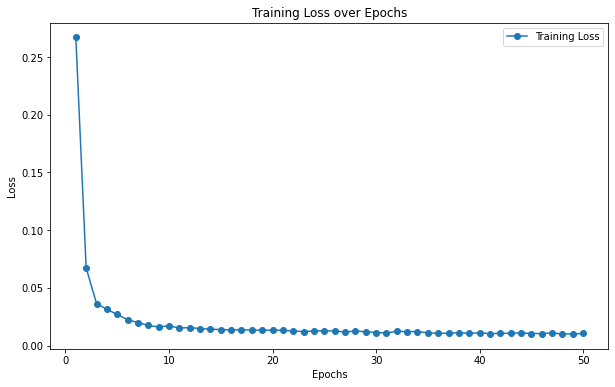

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

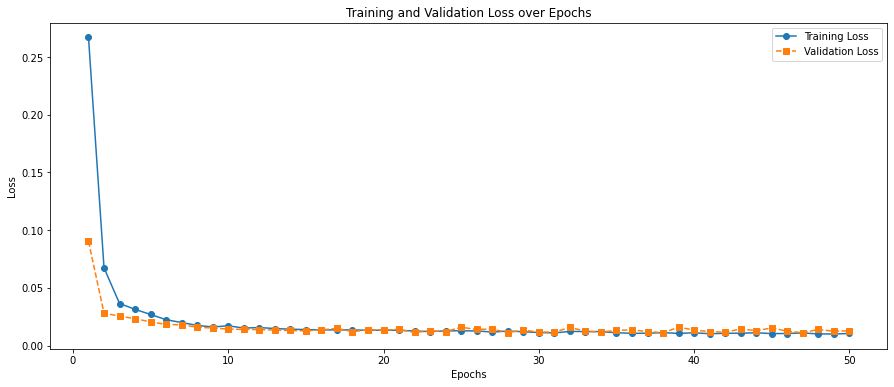

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 35ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0821522137300894
MAE : 0.0629155044924187


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,313513.093750,436530.907
1,254426.343750,283162.646
2,258719.593750,212475.431
3,315242.062500,386546.857
4,418218.125000,547183.986
5,537286.937500,584596.262
6,615666.562500,584830.109
7,663257.500000,641562.292
8,681912.937500,734946.437
9,674272.562500,777596.225


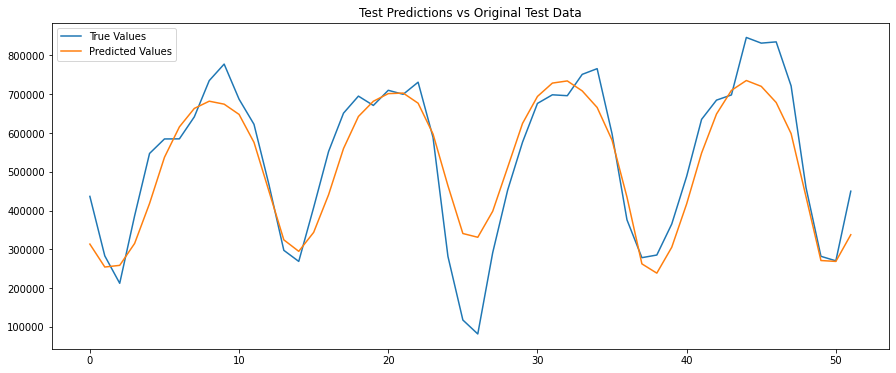

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 33ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

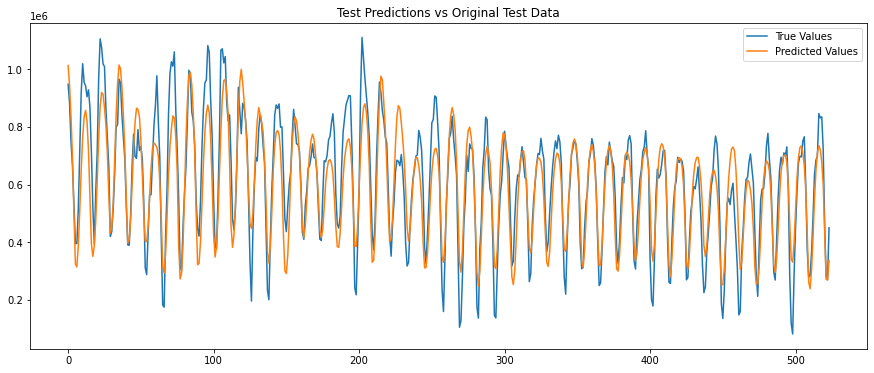

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()